# Chem 277B - Fall 2024 - Homework 6
## CNN - Image Processing Using an Encoder-Decoder Structure
*Submit this notebook to bCourses to receive a credit for this assignment.*
<br>
due: **Nov 18th 2024** 
<br>
**Please upload both, the .ipynb file and the corresponding .pdf**<br>
<br>

## 120 Points Total

**Problem**

Your task is building an anomaly detection model to identify parasitized cells among images of infected and uninfected cells using a deep learning autoencoder structure (see **tutorial 7** at *bCourses*). The goal is to develop a system that detects anomalies based on reconstruction errors and density estimations of encoded features.<br>
The learning goal of this homework assignment is to work on a real-life scenario with a realistic workflow. This task also serves a preparation for the Capstone Project concerning complexity and difficulty. 

## Note: Optimize for Computational Efficiency
Autoencoders require significant computational resources, so consider the following strategies to reduce computation time while maintaining accuracy:

**Use Smaller Image Sizes**: Start with 64, 32, or even 16 pixels. Smaller images can drastically cut computational cost.
Reduce Filters and Layers: Experiment with fewer filters in each layer and avoid building a very dense network. Aim for a trade-off between model complexity and compute efficiency.<br>
<br>

**Skip the Final Conv2D Layer**: Instead of reconstructing at full resolution, consider using a smaller output size, which reduces the computation load without sacrificing much accuracy.<br>


**Consider a Shallow Network**: A simpler encoder-decoder structure with fewer layers may still work effectively for anomaly detection.<br>

**Preprocess Images:** Apply preprocessing techniques such as thresholding to simplify images before passing them through the autoencoder. Smarter preprocessing may reduce the need for a dense network. You may also make this a single channel image with smart pre processing.


These adjustments are intended to balance computational efficiency with detection accuracy. Use these hints to guide your network design and experiment with different configurations for the best trade-off.<br>


Please avoid building a network that takes in **128x128** images without preprocessing. Training such a model will be infeasible with limited compute resources. Although smaller image sizes or simpler networks may not yield the highest possible accuracy, experimenting with these configurations is essential.

Grading will be based on the workflow and application of concepts—not purely on accuracy. Focus on understanding the process and applying techniques for effective anomaly detection with practical constraints. (Hint:- Opencv & KNN)

**Dataset**

The dataset contains images of cell samples, both infected (parasitized) and uninfected (healthy), which can be downloaded from the National Library of Medicine: [Malaria Dataset](https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets)

**Guided Workflow and Hints:**

In [1412]:
import tensorflow as tf
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from PIL import Image




In [1413]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda, Dropout, Layer

from tensorflow.keras.losses import mse
from tensorflow.keras import layers, models, backend as K



In [1414]:
from tensorflow.keras import layers, models




**1) Preprocessing and Data Loading** <br>
> **Objective**: Load and preprocess images of healthy and infected cells.<br> 
> **Hint**: Apply preprocessing techniques such as thresholding to simplify images before passing them through the autoencoder. Smarter preprocessing may reduce the need for a dense network.
You may also make this a single channel image with smart pre processing.

In [1547]:



import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

base_dir = "/Users/stemesghen/Downloads/HW6/cell_images"

def load_balanced_cell_images(base_dir, sample_size=None):
    data = []
    labels = []
    for folder, label in zip(["Parasitized", "Uninfected"], [1, 0]):  # Parasitized (1) and Uninfected (0)
        folder_path = os.path.join(base_dir, folder)
        files = [
            file_name
            for file_name in os.listdir(folder_path)
            if file_name.endswith(('.jpg', '.jpeg', '.png'))
        ]
        if sample_size is not None:
            files = random.sample(files, min(sample_size, len(files)))

        for file_name in files:
            img = Image.open(os.path.join(folder_path, file_name)).convert("L").resize((28, 28))
            data.append(np.array(img) / 255.0)  # Normalize to [0, 1]
            labels.append(label)

    return np.array(data), np.array(labels)

sample_size = 200
labels = np.array(labels)

data, labels = load_balanced_cell_images(base_dir, sample_size)

# Filter only healthy cells for training
uninfected_samples = data[labels == 0]  # Label 0 corresponds to healthy cells
parasitized_samples = data[labels == 1] # Parasitized (label = 1)

# Split healthy samples into training and test sets
x_train, x_test = train_test_split(uninfected_samples, test_size=0.2, random_state=42)

# Reshape for the VAE
x_train = x_train.reshape(len(x_train), 28, 28, 1).astype("float32")
x_test = x_test.reshape(len(x_test), 28, 28, 1).astype("float32")


#reshaping
parasitized_samples = parasitized_samples.reshape(-1, 28, 28, 1).astype("float32")
uninfected_samples = uninfected_samples.reshape(-1, 28, 28, 1).astype("float32")




In [1416]:
#VAE - Autoencoder

latent_dim = 2  # Size of the latent space






**2) Autoencoder Model Setup**<br>
> **Objective**: Build an autoencoder with a bottleneck layer (see **tutorial 7**) to capture compressed representations of cell images.<br>
> **Hint**: Use *Conv2D*, *MaxPooling2D*, and *UpSampling2D* layers to build an encoder-decoder structure. Keep the bottleneck layer relatively small to capture key features in the latent space.<br>
> **Question**: Why is it important to use a small bottleneck layer in anomaly detection with autoencoders?<br>

Answer: If the bottleneck layer is larger, then we can create overfitting and may classify more images as anomalous. It would be more difficult for the model to categorize between parasitized and uninfected images. Reconstruction errors would be lower in comparison to a smaller bottleneck.



In [1417]:

# Encoder
inputs = layers.Input(shape=(28, 28, 1)) 
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)  
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsampling
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)         
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # Downsampling   
x = layers.Flatten()(x)
encoded = layers.Dense(latent_dim, activation="relu")(x)


In [1418]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])


In [1419]:

# Decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_input)
x = layers.Reshape((7, 7, 64))(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsampling
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)  # Upsampling
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
outputs = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)


In [1420]:

# Define encoder and decoder models
encoder = models.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()





Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_78      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 28, 28,    │        320 │ input_layer_78[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_50    │ (None, 14, 14,    │          0 │ conv2d_128[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 14, 14,    │     18,496 │ max_pooling2d_50… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_51    │ (None, 7, 7, 64)  │          0 │ conv2d_129[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_26          │ (None, 3136)      │          0 │ max_pooling2d_51… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      6,274 │ flatten_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      6,274 │ flatten_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,364 (122.52 KB)

 Trainable params: 31,364 (122.52 KB)

 Non-trainable params: 0 (0.00 B)

In [1421]:
decoder = models.Model(decoder_input, outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_79 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_28 (Reshape)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_53 (UpSampling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_54 (UpSampling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [1422]:

# VAE model  - AUTOENCODER
outputs = decoder(encoder(inputs)[2])
vae = models.Model(inputs, outputs, name="vae")

vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_78 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 2), (None, 2), │        31,364 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        65,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,453 (376.77 KB)

 Trainable params: 96,453 (376.77 KB)

 Non-trainable params: 0 (0.00 B)

**4) Evaluation Using Reconstruction Error**<br>
>**Objective:** Evaluate the reconstruction error on both healthy and parasitized cells.<br>
>**Hint:** Calculate the reconstruction error for each type of image. High errors for parasitized cells should indicate anomalies.<br>
>**Question:** Why might parasitized cells have a higher reconstruction error than healthy cells?<br>

Answer: Parasitized cells have a higher reconstruction error because they are harder to reconstruct through the VAE. The model was trained exclusively on healthy cells, and parasitized cells, having a more "de-normalized" shape compared to normal cells, do not effectively pass through the bottleneck layer. As a result, the VAE struggles to reconstruct these anomalous patterns. Parasitized cells can be considered anomalous because they reside in low-probability regions of the latent space, making them inherently harder for the VAE to encode and reconstruct accurately.
 

In [1481]:

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = models.Model(inputs, outputs, name="vae")

# Custom VAE loss function
def vae_loss(inputs, outputs):
    z_mean, z_log_var = encoder(inputs)[:2]
    reconstruction_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(inputs, outputs), axis=(1, 2))
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    return total_loss




# Compile the model with custom loss
vae.compile(optimizer="adam", loss=vae_loss)


In [1504]:

# VAE fitting/train
vae.fit(
    x_train, x_train,  # using x_train as both inputs and outputs since this is an autoencoder
    epochs=50,         #  ------- try increase epochs per Dr.Hohle
    batch_size=128,
    validation_data=(x_test, x_test))

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 412.2075 - val_loss: 441.8917
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 411.4007 - val_loss: 447.7387
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 411.1259 - val_loss: 446.6953
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 410.1857 - val_loss: 445.1451
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 410.5730 - val_loss: 447.7159
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 409.6284 - val_loss: 451.9763
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 411.0636 - val_loss: 447.3581
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 410.4064 - val_loss: 447.3599
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 409.7982 - val_loss: 450.3166
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 410.3199 - val_loss: 450.4366
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 410.1905 - val_loss: 449.5333
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5

In [1505]:
print(inputs.shape)


(None, 28, 28, 1)


In [1506]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("VAE input shape:", vae.input.shape)
print("VAE output shape:", vae.output.shape)


x_train shape: (160, 28, 28, 1)
x_test shape: (40, 28, 28, 1)
VAE input shape: (None, 28, 28, 1)
VAE output shape: (None, 28, 28, 1)


In [1507]:

print(parasitized_samples.shape)
print(uninfected_samples.shape)


(200, 28, 28, 1)
(200, 28, 28, 1)


In [1508]:
#run data samples through VAE

uninfected_reconstruct_vae  = vae.predict(uninfected_samples)# run uninfected images through vae
parasitized_reconstruct_vae= vae.predict(parasitized_samples)# run parasitized images through vae

print(uninfected_reconstruct_vae.shape)
print(parasitized_reconstruct_vae.shape)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(200, 28, 28, 1)
(200, 28, 28, 1)


In [1509]:
uninfected_reconstruct_vae = vae.predict(uninfected_samples)
print("Reconstructed uninfected samples shape:", uninfected_reconstruct_vae.shape)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Reconstructed uninfected samples shape: (200, 28, 28, 1)


In [1510]:


#  calculate reconstruction error (margin of error from original images (before vae) vs. reconstructed (after vae))
def calculate_reconstruction_error(before_vae, after_vae):
    errors = np.mean(np.square(before_vae - after_vae), axis=(1, 2, 3))
    return errors


In [1511]:

# calculate reconstruction errors applied to data
uninfected_reconstruction_errors = calculate_reconstruction_error(uninfected_samples, uninfected_reconstruct_vae)

average_uninfected_reconstruction_errors = np.mean(uninfected_reconstruction_errors)

parasitized_reconstruction_errors = calculate_reconstruction_error(parasitized_samples, parasitized_reconstruct_vae)

average_parasitized_reconstruction_errors = np.mean(parasitized_reconstruction_errors)


print (f'''Mean Calculated Reconstruction Error
       Parasitized: {average_parasitized_reconstruction_errors}
       Uninfected:  {average_uninfected_reconstruction_errors}
       ''')

Mean Calculated Reconstruction Error
       Parasitized: 0.03310062736272812
       Uninfected:  0.011748772114515305
       


In [1512]:
std_uninfected_reconstruction_errors = np.std(uninfected_reconstruction_errors)
std_parasitized_reconstruction_errors = np.std(parasitized_reconstruction_errors)


print (f'''Standard Deviation Calculated Reconstruction Error
       Parasitized: {std_parasitized_reconstruction_errors}
       Uninfected:  {std_uninfected_reconstruction_errors}
       ''')


Standard Deviation Calculated Reconstruction Error
       Parasitized: 0.024932581931352615
       Uninfected:  0.012165304273366928
       


**5) Latent Space Representation and Density Calculation**<br>
>**Objective**: Extract the compressed (latent) representations of the healthy cells from the bottleneck layer and calculate a density threshold for anomaly detection.<br>
>**Hint**: Use *KernelDensity* from *sklearn.neighbors* to fit a density model on the compressed representations of healthy cells, then set a threshold for density values.<br>
>**Question**: What role does density estimation play in enhancing anomaly detection beyond reconstruction error alone?<br>

Having a second form of estimation, such as density estimation, can improve the accuracy of classifying images as parasitized vs. uninfected. Areas of low density in the latent space can be considered anomalous, as parasitized cells are more likely to fall outside the high-density regions where uninfected cells are concentrated.

In [1513]:
from sklearn.neighbors import KernelDensity

np.random.seed(42)
latent_representations = encoder.predict(uninfected_samples)[2]  


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [1514]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.1)  
kde.fit(latent_representations)

KernelDensity(bandwidth=0.1)

In [1515]:

#Density
log_density_scores = kde.score_samples(latent_representations)
density_scores = np.exp(log_density_scores)


#Threshold
threshold = np.quantile(density_scores, 0.02) #Precentile = 2

for density in density_scores:
    if density >= threshold:
        print(f"Density Score {density:.4f} is >= threshold ({threshold:.4f}): Healthy (Uninfected)")
    else:
        print(f"Density Score {density:.4f} is <= threshold ({threshold:.4f}): Anomalous (Parasitized)")



Density Score 0.3024 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.2996 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.1123 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.3078 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.2434 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.0798 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.1294 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.0851 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.0796 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.2209 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.6008 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.1960 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.1665 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.4148 is >= threshold (0.0796): Healthy (Uninfected)
Density Score 0.2441 is >= threshold (0.0796): H

In [1516]:

print("Density scores (uninfected cells):", density_scores[:5])  
print("Density threshold:", threshold)


Density scores (uninfected cells): [0.30237699 0.29957937 0.11229144 0.3078057  0.24338546]
Density threshold: 0.07957747154595692


In [1517]:
#Anomaly  

anomalies = density_scores < threshold
print("Anomaly in uninfected cells:", np.sum(anomalies))

idx = np.where(density_scores <= threshold)
values = uninfected_samples[idx]

Anomaly in uninfected cells: 4


**6) Threshold Setting and Anomaly Detection**<br>
>**Objective**: Define thresholds for density and reconstruction error to classify new images as healthy or parasitized.<br>
>**Hint**: Test different threshold values based on mean and standard deviation of errors in both healthy and parasitized cells.<br>
>**Question**: How would changing the density threshold or reconstruction error threshold affect the model’s performance?<br>

High: 
When I increase the thresholds for either density or reconstruction, more cells were considered uninfected. 


Low: 
When I changed the density or reconstruction threshold by making it lower, there were more anomaly cells. 


Higher the threshold then the more cells will be classified as "uninfected" 

Lower the threshold then the more cells will be classified as "anomalous" 

So it is important to try to find the balance between the thresholds to maximize accuracy of image classification. 


In [1518]:
mean_density = np.mean(density_scores)
std_density = np.std(density_scores)


In [1519]:
#K reconstruction   = 1.5 and k density set at 1.5
threshold_reconstruction_error = average_uninfected_reconstruction_errors + 1.5 * std_uninfected_reconstruction_errors
threshold_density = mean_density - 1.5 * std_density


print(f"Threshold Density: {threshold_density:.4f}")
print(f"Threshold Reconstruction Error: {threshold_reconstruction_error:.4f}")




Threshold Density: 0.0073
Threshold Reconstruction Error: 0.0300


In [1548]:
for error in parasitized_reconstruction_errors:
    if error <= threshold_reconstruction_error:
        print(f"Reconstruction Error {error:.4f} is <= to the threshold ({threshold_reconstruction_error:.4f}): Healthy (Uninfected)")
    else:
        print(f"Reconstruction Error {error:.4f} > than the threshold ({threshold_reconstruction_error:.4f}): Anomalous (Parasitized)")

Reconstruction Error 0.0160 is <= to the threshold (0.0300): Healthy (Uninfected)
Reconstruction Error 0.0236 is <= to the threshold (0.0300): Healthy (Uninfected)
Reconstruction Error 0.0776 > than the threshold (0.0300): Anomalous (Parasitized)
Reconstruction Error 0.0376 > than the threshold (0.0300): Anomalous (Parasitized)
Reconstruction Error 0.0402 > than the threshold (0.0300): Anomalous (Parasitized)
Reconstruction Error 0.0338 > than the threshold (0.0300): Anomalous (Parasitized)
Reconstruction Error 0.0114 is <= to the threshold (0.0300): Healthy (Uninfected)
Reconstruction Error 0.0210 is <= to the threshold (0.0300): Healthy (Uninfected)
Reconstruction Error 0.0162 is <= to the threshold (0.0300): Healthy (Uninfected)
Reconstruction Error 0.0199 is <= to the threshold (0.0300): Healthy (Uninfected)
Reconstruction Error 0.0180 is <= to the threshold (0.0300): Healthy (Uninfected)
Reconstruction Error 0.1395 > than the threshold (0.0300): Anomalous (Parasitized)
Reconstruct

In [1549]:
for error in uninfected_reconstruction_errors:
    if error <= threshold_reconstruction_error:
        print(f"Reconstruction Error for Healthy (Uninfected): {error:.4f}")
    else:
        print(f"Reconstruction Error for  Anomalous (Parasitized): {error:.4f}")


Reconstruction Error for Healthy (Uninfected): 0.0107
Reconstruction Error for Healthy (Uninfected): 0.0052
Reconstruction Error for Healthy (Uninfected): 0.0124
Reconstruction Error for Healthy (Uninfected): 0.0087
Reconstruction Error for Healthy (Uninfected): 0.0058
Reconstruction Error for Healthy (Uninfected): 0.0037
Reconstruction Error for Healthy (Uninfected): 0.0051
Reconstruction Error for Healthy (Uninfected): 0.0027
Reconstruction Error for Healthy (Uninfected): 0.0049
Reconstruction Error for Healthy (Uninfected): 0.0061
Reconstruction Error for Healthy (Uninfected): 0.0065
Reconstruction Error for Healthy (Uninfected): 0.0131
Reconstruction Error for Healthy (Uninfected): 0.0095
Reconstruction Error for Healthy (Uninfected): 0.0065
Reconstruction Error for Healthy (Uninfected): 0.0069
Reconstruction Error for Healthy (Uninfected): 0.0179
Reconstruction Error for Healthy (Uninfected): 0.0265
Reconstruction Error for Healthy (Uninfected): 0.0063
Reconstruction Error for Hea

In [1522]:
reconstruction_errors = np.concatenate([uninfected_reconstruction_errors, parasitized_reconstruction_errors])


In [1523]:
# Combined  Density with Errors for Uninfected and Parasistized Errors
for density, error in zip(density_scores, reconstruction_errors):
    if density >= threshold_density and error <= threshold_reconstruction_error:
        print(f"Density Score = {density:.4f}, Reconstruction Error = {error:.4f}: Healthy")
    else:
        print(f"Density Score = {density:.4f}, Reconstruction Error = {error:.4f}: Parasitized")


Density Score = 0.3024, Reconstruction Error = 0.0107: Healthy
Density Score = 0.2996, Reconstruction Error = 0.0052: Healthy
Density Score = 0.1123, Reconstruction Error = 0.0124: Healthy
Density Score = 0.3078, Reconstruction Error = 0.0087: Healthy
Density Score = 0.2434, Reconstruction Error = 0.0058: Healthy
Density Score = 0.0798, Reconstruction Error = 0.0037: Healthy
Density Score = 0.1294, Reconstruction Error = 0.0051: Healthy
Density Score = 0.0851, Reconstruction Error = 0.0027: Healthy
Density Score = 0.0796, Reconstruction Error = 0.0049: Healthy
Density Score = 0.2209, Reconstruction Error = 0.0061: Healthy
Density Score = 0.6008, Reconstruction Error = 0.0065: Healthy
Density Score = 0.1960, Reconstruction Error = 0.0131: Healthy
Density Score = 0.1665, Reconstruction Error = 0.0095: Healthy
Density Score = 0.4148, Reconstruction Error = 0.0065: Healthy
Density Score = 0.2441, Reconstruction Error = 0.0069: Healthy
Density Score = 0.3601, Reconstruction Error = 0.0179: 

Parasitized Cell Reconstructions


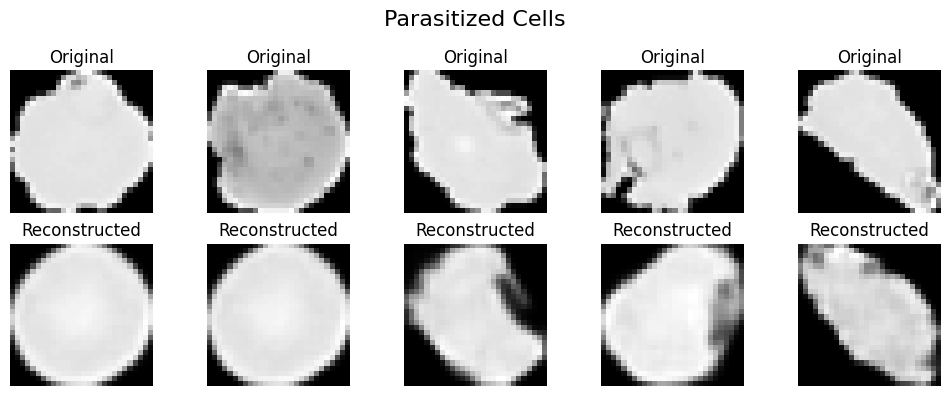

Uninfected Cell Reconstructions


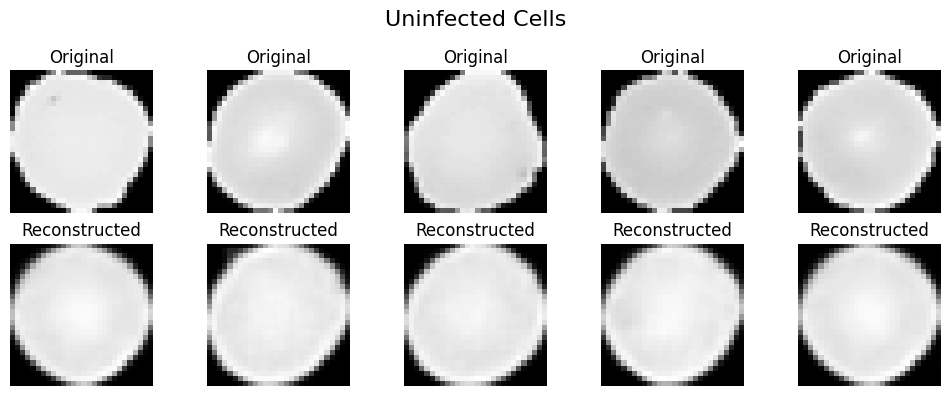

In [1524]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot original and reconstructed images
def plot_reconstructions(original, reconstructed, num_images=5, title="Reconstructions"):
 
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Plot original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Plot reconstructed image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage with parasitized and uninfected samples
# Assuming `parasitized_samples` and `parasitized_reconstruct_vae` exist
print("Parasitized Cell Reconstructions")
plot_reconstructions(parasitized_samples, parasitized_reconstruct_vae, num_images=5, title="Parasitized Cells")

# Assuming `uninfected_samples` and `uninfected_reconstruct_vae` exist
print("Uninfected Cell Reconstructions")
plot_reconstructions(uninfected_samples, uninfected_reconstruct_vae, num_images=5, title="Uninfected Cells")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


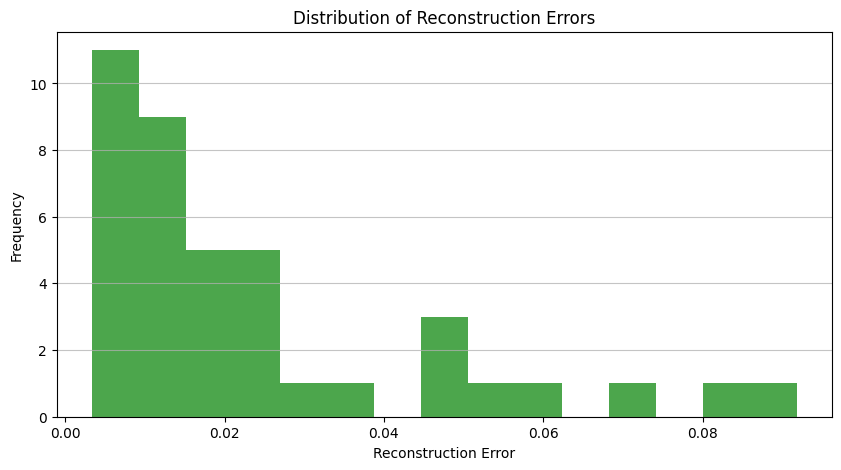

In [1558]:
def plot_reconstruction_errors(x_test, reconstructed_images, n=50):
    """
    Plots a histogram of reconstruction errors.
    """
    # Compute reconstruction errors
    errors = np.mean((x_test[:n] - reconstructed_images[:n])**2, axis=(1, 2, 3))
    
    # Plot histogram of reconstruction errors
    plt.figure(figsize=(10, 5))
    plt.hist(errors, bins=15, color='green', alpha=0.7)
    plt.title("Distribution of Reconstruction Errors")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Usage Example:
# Get reconstructed images
z_mean, _, _ = encoder.predict(x_test)
reconstructed_images = decoder.predict(z_mean)

# Plot the reconstruction errors
plot_reconstruction_errors(x_test, reconstructed_images, n=100)


**7) Testing on New Images**<br>
>**Objective**: Test the model’s performance on a mix of new healthy and parasitized images.<br>
>**Hint**: Use the *check_anomaly* function to predict whether new images are anomalies. Adjust threshold values if necessary.<br>
>**Question**: What can you conclude if a healthy cell image is incorrectly classified as parasitized?<br>

As previously stated, if a healthy cell image is classified as parasitized, it could come from my threshold being set too low causing overfitting. It can also be from the image size, batch, and/or epoch size. 
Latent dimension can be too small. 
Image size may be too small - missing key features. 
Batch size - too large, can affecting performance
epoch size  - lower epoch can cause undertraining and lead to overfitting as well. 


NOTES: 

Anomaly: have high reconstruction error because the VAE could not construct it well. If there is a low density score then that means it doesnt belong to the normal region of the latent space

parasistized cells have anaomiles (high reconstruction errors because they are harder to reconstruct. Thus, they are low probability in latent space). 


Latent space has a Healthy cells (normal) vs. Parasitized cells (anomalies)
 - Healthy are clustered arounf the center and represent high-probability regions
 - Anomolies/Parasitized  - spread far from the center and low probability regions. 


In [1526]:
#### NEW CODE TO IMPLEMENT##

In [1527]:
new_base_dir = "/Users/stemesghen/Downloads/HW6/cell_images"
new_data, new_labels = load_balanced_cell_images(new_base_dir, sample_size)


Loaded 200 images from 'Parasitized' folder.
Loaded 200 images from 'Uninfected' folder.


In [1550]:
def check_anomaly_new_images(density_score, reconstruction_error, threshold_density, threshold_reconstruction_error):
    """
    Classify an image as healthy or parasitized based on density score and reconstruction error.
    
    """
    if density_score < threshold_density or reconstruction_error > threshold_reconstruction_error:
        return "Parasitized"
    else:
        return "Healthy"

In [1556]:
 # Test new images

new_data = new_data.reshape(-1, 28, 28, 1).astype("float32")



# NEW Latent Representations and Reconstruction ERRORS
latent_representations_new = encoder.predict(new_data)[2]
reconstructed_new_images = vae.predict(new_data)
new_reconstruction_errors = calculate_reconstruction_error(new_data, reconstructed_new_images)


# NEW density scores
log_density_scores_new = kde.score_samples(latent_representations_new)
density_scores_new = np.exp(log_density_scores_new)

# Classify new images
predicted_labels = [
    0 if density_score >= threshold_density and reconstruction_error <= threshold_reconstruction_error else 1
    for density_score, reconstruction_error in zip(density_scores_new, new_reconstruction_errors)
]

# TRAIN NEW data
train_data, test_data, train_labels, test_labels = train_test_split(
    new_data, new_labels, test_size=0.2, random_state=42
)


# Evaluate model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(new_labels, predicted_labels)
precision = precision_score(new_labels, predicted_labels)
recall = recall_score(new_labels, predicted_labels)
f1 = f1_score(new_labels, predicted_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")







13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.61
Precision: 0.65
Recall: 0.47
F1 Score: 0.54


VISUALIZATION 



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


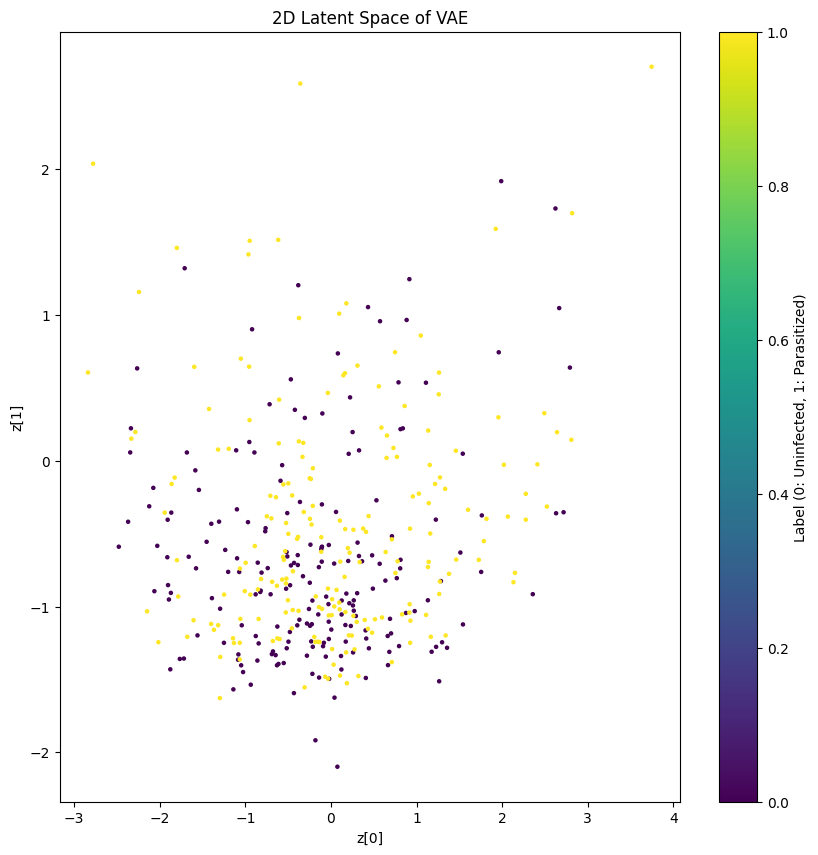

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

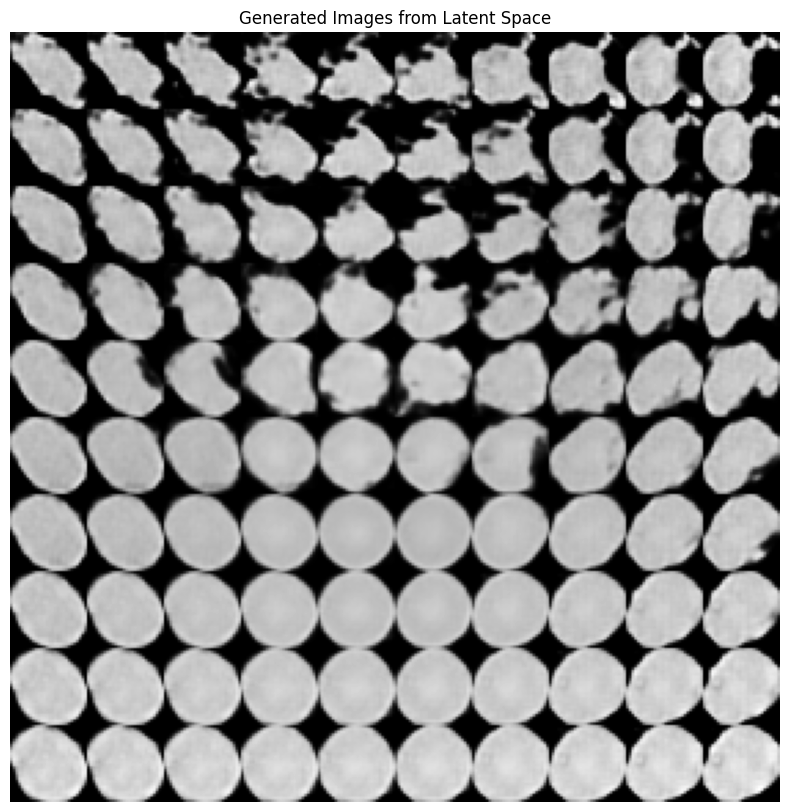

In [1554]:
# Function to plot the latent space with labels
def plot_latent_space(encoder, uninfected_samples, parasitized_samples):
    # Get latent space representations for both classes
    z_uninfected = encoder.predict(uninfected_samples)[2]
    z_parasitized = encoder.predict(parasitized_samples)[2]

    # Create labels for the two classes
    labels_uninfected = np.zeros(len(z_uninfected))  # Label 0 for uninfected
    labels_parasitized = np.ones(len(z_parasitized))  # Label 1 for parasitized

    # Combine data and labels
    z_combined = np.concatenate([z_uninfected, z_parasitized])
    labels_combined = np.concatenate([labels_uninfected, labels_parasitized])

    # Plot the latent space
    plt.figure(figsize=(10, 10))
    plt.scatter(z_combined[:, 0], z_combined[:, 1], c=labels_combined, cmap='viridis', s=5)
    plt.colorbar(label="Label (0: Uninfected, 1: Parasitized)")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("2D Latent Space of VAE")
    plt.show()

# Plot the latent space
plot_latent_space(encoder, uninfected_samples, parasitized_samples)

# Function to generate and visualize images by tweaking the latent vector
def visualize_latent_images(decoder, n=10, range_min=-3, range_max=3):
    img_width, img_height, num_channels = 28, 28, 1
    figure = np.zeros((img_width * n, img_height * n))

    # Define grid of values in latent space
    grid_x = np.linspace(range_min, range_max, n)
    grid_y = np.linspace(range_min, range_max, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            image = x_decoded[0].reshape(img_width, img_height)
            figure[i * img_width: (i + 1) * img_width,
                   j * img_height: (j + 1) * img_height] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.axis('off')
    plt.title("Generated Images from Latent Space")
    plt.show()

# Visualize images generated from the latent space
visualize_latent_images(decoder)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


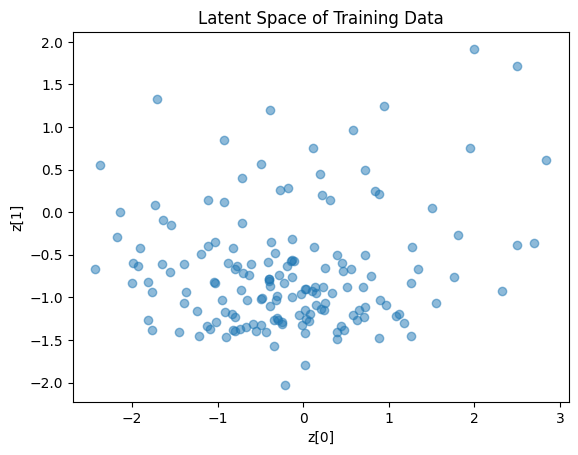

In [1557]:
z_mean, _, _ = encoder.predict(x_train)
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space of Training Data")
plt.show()


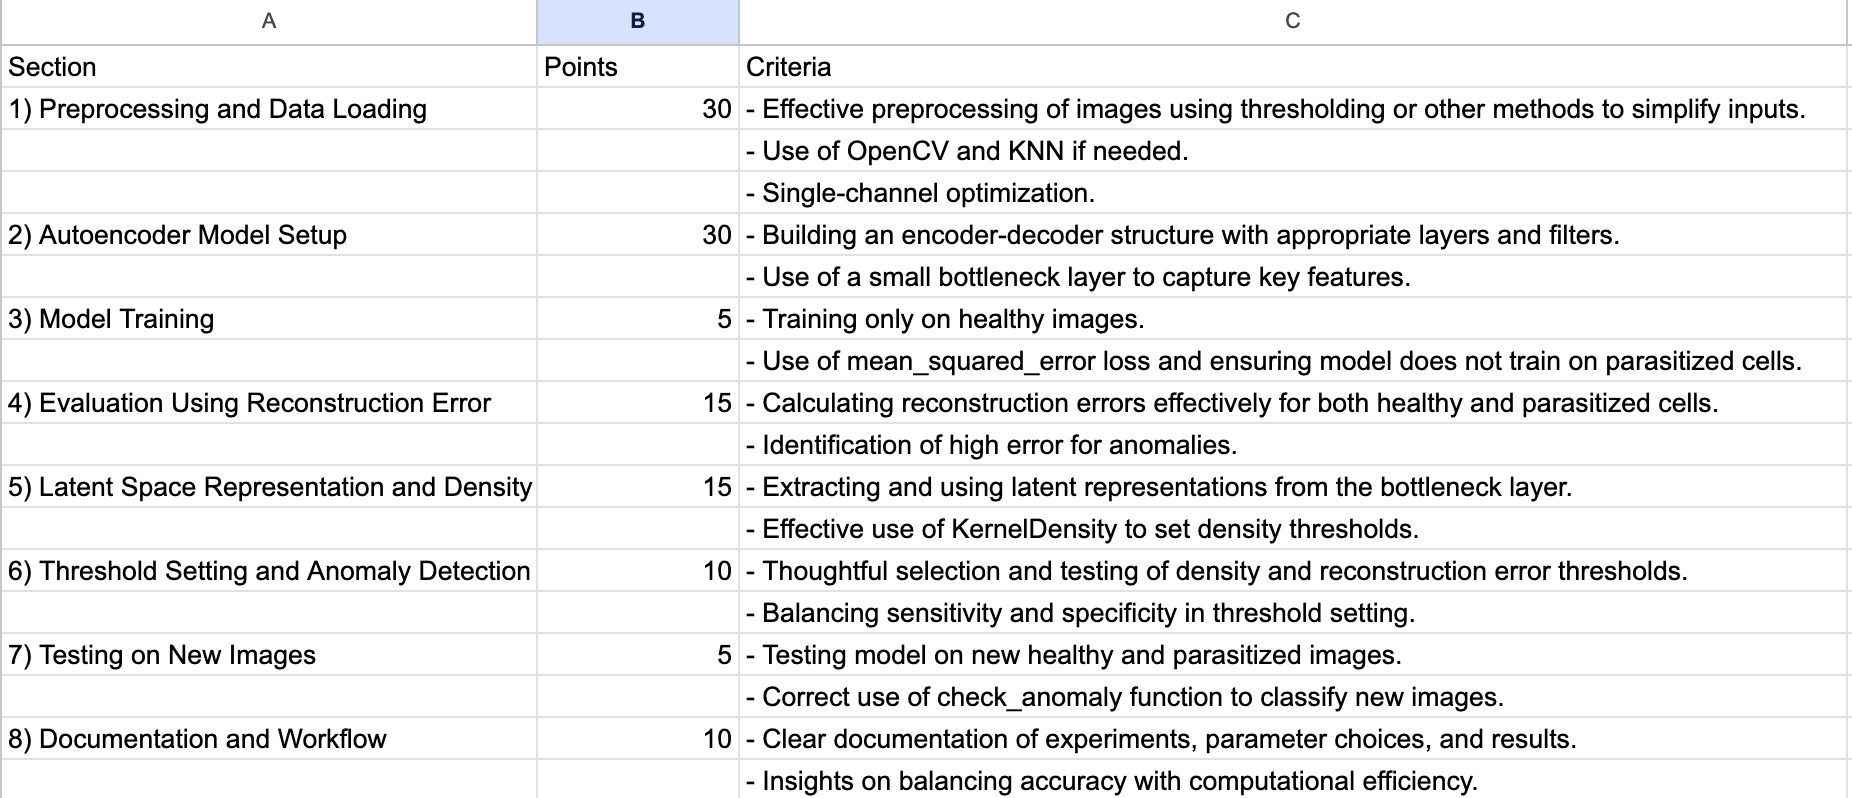